## Download data from Kaggle

In [1]:
import pandas as pd
import numpy as np
import re
import gc, sys
from tqdm import tqdm_notebook as tqdm
import pytz
import matplotlib.pyplot as plt
import datetime

pd.set_option('display.max_columns', 500)

In [2]:
!kaggle competitions download ml-f19
    
!unzip -o ml-f19.zip -d ../data/
!rm ml-f19.zip


  0%|                                                | 0.00/847k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 847k/847k [00:00<00:00, 21.0MB/s]
Archive:  ml-f19.zip
  inflating: ../data/sample_submission.csv  
  inflating: ../data/skeleton_code.py  
  inflating: ../data/test.csv        
  inflating: ../data/train.csv       


## Loading data

In [3]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

display(train.head(2))
display(test.head(2))

,Unnamed: 0,date,org,tld,ccs,bcced,mail_type,images,urls,salutations,designation,chars_in_subject,chars_in_body,label
0,0,"Sun, 28 Aug 2016 00:17:44 +0000",amazon,in,0,0,multipart/mixed,0,0,0,0,102,4,3
1,1,"Mon, 13 Jun 2016 07:17:24 +0000 (UTC)",linkedin,com,0,0,multipart/alternative,15,44,0,0,55,35444,1


,Unnamed: 0,date,org,tld,ccs,bcced,mail_type,images,urls,salutations,designation,chars_in_subject,chars_in_body
0,0,"Tue, 22 Sep 2015 10:09:26 +0530",iiitd,ac.in,0,0,multipart/mixed,0,0,0,0,39,955708
1,1,"Wed, 8 Nov 2017 10:03:00 +0000",mail,paypal.com,0,0,multipart/alternative,31,165,1,0,53,137106


## Class balancing

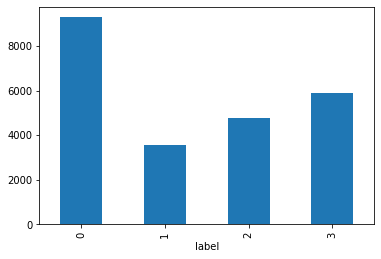

label
0    0.374034
1    0.144082
2    0.192593
3    0.237882
Name: org, dtype: float64

In [4]:
train.groupby('label')['org'].count().plot(kind='bar')

plt.show()

train.groupby('label')['org'].count()/len(train)

## Missing values org and tld
entries with null org and tld have a great chance to be in update category.
Add this information under column Null_sender

In [5]:
# Identify missing values 
import math
w=float('nan')
math.isnan(w)
train.isna().sum() # 1277 missing values for org/tld (same observation)

# Investigate these missing obs, where the input is nan
train[train['org'].isnull()].label.value_counts() #  1170 are labelled 0 

# Identify missing values for test - variable is going to be useful ! 
import math
w=float('nan')
math.isnan(w)
test.isna().sum() # 583 missing values for org/tld (same observation)


# Create variable 
train['Null_sender'] = (train['org'].isnull()) & (train['tld'].isnull())
train['Null_sender'] = 1 - (pd.get_dummies(train['Null_sender']))  # want 1 on NaN values, not the opposite
test['Null_sender'] = (test['org'].isnull()) & (test['tld'].isnull())
test['Null_sender'] = 1 - (pd.get_dummies(test['Null_sender']))

## Processing the date
- apply a regular expression to parse the date
- the extract relevent information as day, month...

In [6]:
def ExtractDate(s):
    re_exp = '(0[\d]|[\d]|[12]\d|3[01])([ |-]+)([\D]{3})([ |-]+)([\d]{4}) ([\d]{2}):([\d]{2}):([\d]{2})([ ]+)?([\+|-][01][\d][0-5][\d]|\(?[\D]{3}\)?){0,1}'
    groups = re.match(re_exp, s.strip()).groups()
    
    date = None
    timeZoneGap = None
    
    if groups[-1] is None: #No timezone information -> process date as UTC
        date = pd.to_datetime(' '.join(groups[i] for i in [0, 2, 4, 5, 6, 7]), format='%d %b %Y %H %M %S')
        date = date.tz_localize(pytz.timezone("UTC"))
        timezone = None
        
        return date, 0
    
    elif groups[-1].startswith('+') or groups[-1].startswith('-') : #timezone as UTC offset, eg '+0500'
        date = pd.to_datetime(' '.join(groups[i] for i in [0, 2, 4, 5, 6, 7]), format='%d %b %Y %H %M %S')
        date = date.tz_localize(pytz.timezone("UTC"))
        dateTimeZone =  pd.to_datetime(' '.join(groups[i] for i in [0, 2, 4, 5, 6, 7, 9]), 
                                       format='%d %b %Y %H %M %S %z') 
        timeZoneGap = date - dateTimeZone.tz_convert(pytz.timezone("UTC"))
    else: #timezone as text : 'UTC' or '(UTC)'
        date_wo_tzone = ' '.join(groups[i] for i in [0, 2, 4, 5, 6, 7])
        if groups[9].startswith('('):
            tzone = groups[9][1:-1]
        else:
            tzone = groups[9]
            
        date = pd.to_datetime(' '.join(groups[i] for i in [0, 2, 4, 5, 6, 7]), format='%d %b %Y %H %M %S')
        date = date.tz_localize(pytz.timezone("UTC"))    
        dateTimeZone = pd.to_datetime(f'{date_wo_tzone} {tzone}', format='%d %b %Y %H %M %S %Z') 
        timeZoneGap = date - dateTimeZone.tz_convert(pytz.timezone("UTC"))
        
    return date, timeZoneGap.seconds/3600

print(ExtractDate('01 Aug 2016 00:17:44 +0000'))
print(ExtractDate('01 Aug 2016 00:17:44 +0800'))
print(ExtractDate('01 Aug 2016 00:17:44 -0800'))
print(ExtractDate('13 Jun 2016 07:17:24 (UTC)'))
print(ExtractDate('13 Jun 2016 07:17:24 GMT'))
print(ExtractDate('11-MAR-2018 20:40:58'))
print(ExtractDate('13 Mar 2013 15:03:16 +0530 (IST)'))

(Timestamp('2016-08-01 00:17:44+0000', tz='UTC'), 0.0)
(Timestamp('2016-08-01 00:17:44+0000', tz='UTC'), 8.0)
(Timestamp('2016-08-01 00:17:44+0000', tz='UTC'), 16.0)
(Timestamp('2016-06-13 07:17:24+0000', tz='UTC'), 0.0)
(Timestamp('2016-06-13 07:17:24+0000', tz='UTC'), 0.0)
(Timestamp('2018-03-11 20:40:58+0000', tz='UTC'), 0)
(Timestamp('2013-03-13 15:03:16+0000', tz='UTC'), 5.5)


In [7]:
def TransformDateStringToDatetime(df):
    df['date'], df['SenderTimeZoneDif'] = zip(*df['date'].apply(lambda s : ExtractDate(s.split(',')[-1])))
    return df
    
train = TransformDateStringToDatetime(train)
test = TransformDateStringToDatetime(test)

In [8]:
print(train['date'].min(), train['date'].max())
print(test['date'].min(), test['date'].max())


2012-04-20 09:43:03+00:00 2019-10-30 12:05:13+00:00
2012-04-20 16:59:14+00:00 2019-10-31 08:20:54+00:00


In [9]:
def GetWeekDayAndHours(df):
    df['week_day'] = df['date'].apply(lambda s : s.day_name())
    
    #convert categorical data into indicator columns
    df = df.join(pd.get_dummies(df['week_day'], prefix='Cat'))
    
    #get the hour of the day
    df['Hour'] = df['date'].apply(lambda s : s.hour)
    # df = df.join(pd.get_dummies(df['Hour'], prefix='Cat_Hour'))
    df['Hour'] = df['Hour']//6
    df = df.join(pd.get_dummies(df['Hour'], prefix='Cat_Hour_bucket'))
    
    df.drop(columns=['week_day', 'Hour'], inplace=True)
    
    return df

#train = GetWeekDayAndHours(train)
#test = GetWeekDayAndHours(test)

In [10]:
# Consider the year
def GetYear(df):
    df['Year'] = df['date'].apply(lambda s : s.year)
    df = df.join(pd.get_dummies(df['Year'], prefix='Cat_Year'))
    return df

# Get dummies weekday and buckets hours
#train = GetYear(train)
#test = GetYear(test)


# Consider the month 
# study Trimester
def GetMonth(df):
    df['Month'] = df['date'].apply(lambda s : s.month)
    df = df.join(pd.get_dummies(df['Month'], prefix='Cat_Month'))
    df['Cat_Trim_1'] = df[['Cat_Month_1', 'Cat_Month_2', 'Cat_Month_3']].max(axis=1)
    df['Cat_Trim_2'] = df[['Cat_Month_4', 'Cat_Month_5', 'Cat_Month_6']].max(axis=1)
    df['Cat_Trim_3'] = df[['Cat_Month_7', 'Cat_Month_8', 'Cat_Month_9']].max(axis=1)
    df['Cat_Trim_4'] = df[['Cat_Month_10', 'Cat_Month_11', 'Cat_Month_12']].max(axis=1)
    df.drop(columns= ['Cat_Month_1', 'Cat_Month_2', 'Cat_Month_3','Cat_Month_4', 'Cat_Month_5', 'Cat_Month_6', 'Cat_Month_7', 'Cat_Month_8', 'Cat_Month_9','Cat_Month_10', 'Cat_Month_11', 'Cat_Month_12'], inplace=True)
    return df

# Get dummies weekday and buckets hours
#train = GetMonth(train)
#test = GetMonth(test)

In [11]:
train.columns

Index(['Unnamed: 0', 'date', 'org', 'tld', 'ccs', 'bcced', 'mail_type',
       'images', 'urls', 'salutations', 'designation', 'chars_in_subject',
       'chars_in_body', 'label', 'Null_sender', 'SenderTimeZoneDif'],
      dtype='object')

## metrics from senders
For each sender, compute on the overall dataset the mean and variance of the email send for minutes, hours, months

In [12]:
#computing the email sender for train and test
train['sender'] = train['org'] + '.' + train['tld']
train['sender'] = train['sender'].str.lower()
test['sender'] = test['org'] + '.' + test['tld']
test['sender'] = test['sender'].str.lower()

In [13]:
def addSendersMetrics(df, df_merged):
    '''
    For each sender from df_merged, compute the number of emails sent on the overall dataset 
    and the mean and variance of the email send for minutes, hours, months
    
    df_merged: the dataset use for metric computation, normally train + test
    df : df that will be enriched with the metrics
    '''
    #compute the number of email send from sender:
    data = df_merged.groupby('sender')['Unnamed: 0'].count().rename('sender_count')
    df = df.join(data, on = ['sender'], how ='left')
    
    #add to df_merged datetime indicatord
    df_merged['Minute'] = df_merged['date'].apply(lambda s : s.minute)
    df_merged['Hour'] = df_merged['date'].apply(lambda s : s.hour)
    df_merged['Day'] = df_merged['date'].apply(lambda s : s.day)
    df_merged['Week'] = df_merged['date'].apply(lambda s : s.week)
    df_merged['Month'] = df_merged['date'].apply(lambda s : s.month)
    df_merged['Year'] = df_merged['date'].apply(lambda s : s.year)
    df['Minute'] = df['date'].apply(lambda s : s.minute)
    df['Hour'] = df['date'].apply(lambda s : s.hour)
    df['Day'] = df['date'].apply(lambda s : s.day)
    df['Week'] = df['date'].apply(lambda s : s.week)
    df['Month'] = df['date'].apply(lambda s : s.month)
    df['Year'] = df['date'].apply(lambda s : s.year)
    
    #compute mean and variance for each previous indicator
    for item in ['Minute','Hour','Day','Week','Month','Year','chars_in_body','chars_in_subject','images', 'urls', 'ccs']:
        for indicator in ['mean', 'std']:
            data = df_merged.groupby('sender')[item].agg(indicator).rename(f'sender_{item}_{indicator}')
            df = df.join(data, on = ['sender'], how ='left')
        
        #compute gap of email with mean and compute ratio 'gap_with_mean / std'
        df[f'gap_{item}_mean'] = df[item] - df[f'sender_{item}_mean']
        df[f'ratio_gap_{item}_std'] = np.divide(df[f'gap_{item}_mean'], df[f'sender_{item}_std'], 
                                                out=np.zeros_like(df[f'gap_{item}_mean']), 
                                                where=df[f'sender_{item}_std']!=0)

    #compute count, mean and variance behaviour for current week and current month
    df_merged['Week_in_Year'] = df_merged['Year'].astype(str) + '_' + df_merged['Week'].astype(str)
    df_merged['Month_in_Year'] = df_merged['Year'].astype(str) + '_' + df_merged['Month'].astype(str)
    
    df['Week'] = df['date'].apply(lambda s : s.week)
    df['Month'] = df['date'].apply(lambda s : s.month)
    df['Year'] = df['date'].apply(lambda s : s.year)
    df['Week_in_Year'] = df['Year'].astype(str) + '_' + df['Week'].astype(str)
    df['Month_in_Year'] = df['Year'].astype(str) + '_' + df['Month'].astype(str)
    
    df['CountByMonth'] = df.groupby(['sender', 'Month_in_Year'])['Unnamed: 0'].transform('count')
    df['CountByWeek'] = df.groupby(['sender', 'Week_in_Year'])['Unnamed: 0'].transform('count')
    
    for item in ['Minute','Hour','Day','Week','chars_in_body','chars_in_subject','images', 'urls', 'ccs']:
        for indicator in ['mean', 'std']:
            data = (df_merged.groupby(['sender', 'Month_in_Year'])[item]
                    .agg(indicator).rename(f'senderByMonth_{item}_{indicator}'))
            df = df.join(data, on = ['sender', 'Month_in_Year'], how ='left')
              
            if item != 'Week':
                data = (df_merged.groupby(['sender', 'Week_in_Year'])[item]
                        .agg(indicator).rename(f'senderByWeek_{item}_{indicator}'))
                df = df.join(data, on = ['sender', 'Week_in_Year'], how ='left')
                #compute gap of email with mean and compute ratio 'gap_with_mean / std'
                
        #compute gap of email with mean and compute ratio 'gap_with_mean / std'
        df[f'gapByMonth_{item}_mean'] = df[item] - df[f'senderByMonth_{item}_mean']
        df[f'ratio_gapByMonth_{item}_std'] = np.divide(df[f'gapByMonth_{item}_mean'], 
                                                   df[f'senderByMonth_{item}_std'], 
                                            out=np.zeros_like(df[f'gapByMonth_{item}_mean']), 
                                            where=df[f'senderByMonth_{item}_std']!=0)
        if item != 'Week':
            df[f'gapByWeek_{item}_mean'] = df[item] - df[f'senderByWeek_{item}_mean']
            df[f'ratio_gapByWeek_{item}_std'] = np.divide(df[f'gapByWeek_{item}_mean'], 
                                                       df[f'senderByWeek_{item}_std'], 
                                                out=np.zeros_like(df[f'gapByWeek_{item}_mean']), 
                                                where=df[f'senderByWeek_{item}_std']!=0)
                    
    #remove not needed columns
    df.drop(columns=['Week', 'Month', 'Year', 'Week_in_Year', 
                     'Month_in_Year','Minute','Hour','Day','Week',
                     'Month','Year'], inplace=True)
                
    return df

df_merged = pd.concat([train, test], sort=False)
train = addSendersMetrics(train, df_merged)
test = addSendersMetrics(test, df_merged)

In [14]:
train

,Unnamed: 0,date,org,tld,ccs,bcced,mail_type,images,urls,salutations,designation,chars_in_subject,chars_in_body,label,Null_sender,SenderTimeZoneDif,sender,sender_count,sender_Minute_mean,sender_Minute_std,gap_Minute_mean,ratio_gap_Minute_std,sender_Hour_mean,sender_Hour_std,gap_Hour_mean,ratio_gap_Hour_std,sender_Day_mean,sender_Day_std,gap_Day_mean,ratio_gap_Day_std,sender_Week_mean,sender_Week_std,gap_Week_mean,ratio_gap_Week_std,sender_Month_mean,sender_Month_std,gap_Month_mean,ratio_gap_Month_std,sender_Year_mean,sender_Year_std,gap_Year_mean,ratio_gap_Year_std,sender_chars_in_body_mean,sender_chars_in_body_std,gap_chars_in_body_mean,ratio_gap_chars_in_body_std,sender_chars_in_subject_mean,sender_chars_in_subject_std,gap_chars_in_subject_mean,ratio_gap_chars_in_subject_std,sender_images_mean,sender_images_std,gap_images_mean,ratio_gap_images_std,sender_urls_mean,sender_urls_std,gap_urls_mean,ratio_gap_urls_std,sender_ccs_mean,sender_ccs_std,gap_ccs_mean,ratio_gap_ccs_std,CountByMonth,CountByWeek,senderByMonth_Minute_mean,senderByWeek_Minute_mean,senderByMonth_Minute_std,senderByWeek_Minute_std,gapByMonth_Minute_mean,ratio_gapByMonth_Minute_std,gapByWeek_Minute_mean,ratio_gapByWeek_Minute_std,senderByMonth_Hour_mean,senderByWeek_Hour_mean,senderByMonth_Hour_std,senderByWeek_Hour_std,gapByMonth_Hour_mean,ratio_gapByMonth_Hour_std,gapByWeek_Hour_mean,ratio_gapByWeek_Hour_std,senderByMonth_Day_mean,senderByWeek_Day_mean,senderByMonth_Day_std,senderByWeek_Day_std,gapByMonth_Day_mean,ratio_gapByMonth_Day_std,gapByWeek_Day_mean,ratio_gapByWeek_Day_std,senderByMonth_Week_mean,senderByMonth_Week_std,gapByMonth_Week_mean,ratio_gapByMonth_Week_std,senderByMonth_chars_in_body_mean,senderByWeek_chars_in_body_mean,senderByMonth_chars_in_body_std,senderByWeek_chars_in_body_std,gapByMonth_chars_in_body_mean,ratio_gapByMonth_chars_in_body_std,gapByWeek_chars_in_body_mean,ratio_gapByWeek_chars_in_body_std,senderByMonth_chars_in_subject_mean,senderByWeek_chars_in_subject_mean,senderByMonth_chars_in_subject_std,senderByWeek_chars_in_subject_std,gapByMonth_chars_in_subject_mean,ratio_gapByMonth_chars_in_subject_std,gapByWeek_chars_in_subject_mean,ratio_gapByWeek_chars_in_subject_std,senderByMonth_images_mean,senderByWeek_images_mean,senderByMonth_images_std,senderByWeek_images_std,gapByMonth_images_mean,ratio_gapByMonth_images_std,gapByWeek_images_mean,ratio_gapByWeek_images_std,senderByMonth_urls_mean,senderByWeek_urls_mean,senderByMonth_urls_std,senderByWeek_urls_std,gapByMonth_urls_mean,ratio_gapByMonth_urls_std,gapByWeek_urls_mean,ratio_gapByWeek_urls_std,senderByMonth_ccs_mean,senderByWeek_ccs_mean,senderByMonth_ccs_std,senderByWeek_ccs_std,gapByMonth_ccs_mean,ratio_gapByMonth_ccs_std,gapByWeek_ccs_mean,ratio_gapByWeek_ccs_std
0,0,2016-08-28 00:17:44+00:00,amazon,in,0,0,multipart/mixed,0,0,0,0,102,4,3,0,0.0,amazon.in,1676.0,24.942721,16.578650,-7.942721,-0.479093,5.447494,6.118061,-5.447494,-0.890395,15.713007,8.612832,12.286993,1.426592,26.462411,14.043996,7.537589,0.536713,6.517303,3.226985,1.482697,0.459468,2017.489857,0.920359,-1.489857,-1.618777,39311.581742,4.141167e+04,-39307.581742,-0.949191,50.644988,25.912548,51.355012,1.981859,9.502387,11.356555,-9.502387,-0.836731,79.059069,81.329729,-79.059069,-0.972081,0.000000,0.000000,0.000000,0.000000,24.0,6.0,20.058824,24.142857,16.685943,16.974771,-3.058824,-0.183317,-7.142857,-0.420793,3.117647,0.714286,4.409114,1.112697,-3.117647,-0.707092,-0.714286,-0.641941,15.764706,25.000000,8.855948,2.160247,12.235294,1.381591,3.000000,1.388730,32.705882,1.268008,1.294118,1.020591,562.058824,4.000000,3.254014e+03,0.000000e+00,-558.058824,-0.171499,0.000000,0.000000,45.794118,59.857143,24.849583,31.986604,56.205882,2.261844,42.142857,1.317516,0.088235,0.000000,0.514496,0.000000,-0.088235,-0.171499,0.000000,0.000000,1.058824,0.000000,6.173949,0.000000,-1.058824,-0.171499,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,2016-06-13 07:17:24+00:00,linkedin,

## Processing mail type
Convert categorical data to indicator columns

'multipart/mixed', 'multipart/alternative', 'text/html',
'text/plain', nan, 'multipart/related', 'text/html ',
'multipart/idm'

In [15]:
def ConvertMailTypeToIndicators(df):
    df['mail_type'] = df['mail_type'].str.lower()
    df['mail_type'] = df['mail_type'].apply(lambda x : str(x).strip())
    df = df.join(pd.get_dummies(df['mail_type'], prefix='Cat_MailType'))
    df.drop(columns=['mail_type'], inplace=True)
    return df

train = ConvertMailTypeToIndicators(train)
test = ConvertMailTypeToIndicators(test)
#add missing mail type on test
test['Cat_MailType_multipart/idm'] = 0

In [16]:
def cleanOrgAndTld(df):
    for col in ['org', 'tld']:
        df[col]=df[col].str.lower()
        df[col]=df[col].apply(lambda s : str(s).strip())
    return df

print('Number of org and tld before cleaning')
print('org in train :', len(train['org'].unique()))
print('org in test :', len(test['org'].unique()))

print('tld in train :', len(train['tld'].unique()))
print('tld in test :', len(test['tld'].unique()))


train = cleanOrgAndTld(train)
test = cleanOrgAndTld(test)

print('Number of org and tld after cleaning')
print('org in train :', len(train['org'].unique()))
print('org in test :', len(test['org'].unique()))

print('tld in train :', len(train['tld'].unique()))
print('tld in test :', len(test['tld'].unique()))

Number of org and tld before cleaning
org in train : 656
org in test : 481
tld in train : 191
tld in test : 143
Number of org and tld after cleaning
org in train : 649
org in test : 474
tld in train : 188
tld in test : 141


## Processing organization
Data analysis shows that on train data, organization from Forum are exclusive from Social
=> We will add two indicators : Cat_is_known_forum_org, Cat_is_known_social_org

In [17]:
"""
#identify row where tld and org are null
train['Cat_Null_sender'] = (train['org'].isnull()) & (train['tld'].isnull())
train['Cat_Null_sender'] = train['Cat_Null_sender'].astype(int)
test['Cat_Null_sender'] = (test['org'].isnull()) & (test['tld'].isnull())
test['Cat_Null_sender'] = test['Cat_Null_sender'].astype(int)
"""

"\n#identify row where tld and org are null\ntrain['Cat_Null_sender'] = (train['org'].isnull()) & (train['tld'].isnull())\ntrain['Cat_Null_sender'] = train['Cat_Null_sender'].astype(int)\ntest['Cat_Null_sender'] = (test['org'].isnull()) & (test['tld'].isnull())\ntest['Cat_Null_sender'] = test['Cat_Null_sender'].astype(int)\n"

In [18]:
# train[train['Cat_Null_sender'] == 1]

In [19]:
"""
#look at intersection accross labels
update_set = set(train[train['label']==0]['org'].unique())
social_set = set(train[train['label']==1]['org'].unique())
forum_set = set(train[train['label']==2]['org'].unique())
promo_set = set(train[train['label']==3]['org'].unique())

print('update set len' , len(update_set))
print('inter forum ' , len(update_set.intersection(forum_set)),
     'inter social ' , len(update_set.intersection(social_set)),
     'inter promo ' , len(update_set.intersection(promo_set)))

print('social set' , len(social_set))
print('inter forum ' , len(social_set.intersection(forum_set)),
     'inter update ' , len(social_set.intersection(update_set)),
     'inter promo ' , len(social_set.intersection(promo_set)))

print('forum set' , len(forum_set))
print('inter social ' , len(forum_set.intersection(social_set)),
     'inter update ' , len(forum_set.intersection(update_set)),
     'inter promo ' , len(forum_set.intersection(promo_set)))

print('promo set' , len(promo_set))
print('inter social ' , len(promo_set.intersection(social_set)),
     'inter update ' , len(promo_set.intersection(update_set)),
     'inter forum ' , len(promo_set.intersection(forum_set)))

#look at intersection between train and test
train_org = set(train['org'].unique())
test_org = set(test['org'].unique())

print('nb org train :', len(train_org), 'nb org test :', len(test_org))
print('intersection :',len(train_org.intersection(test_org)))


print('forum set :', forum_set)
print('social set :', social_set)
"""

"\n#look at intersection accross labels\nupdate_set = set(train[train['label']==0]['org'].unique())\nsocial_set = set(train[train['label']==1]['org'].unique())\nforum_set = set(train[train['label']==2]['org'].unique())\npromo_set = set(train[train['label']==3]['org'].unique())\n\nprint('update set len' , len(update_set))\nprint('inter forum ' , len(update_set.intersection(forum_set)),\n     'inter social ' , len(update_set.intersection(social_set)),\n     'inter promo ' , len(update_set.intersection(promo_set)))\n\nprint('social set' , len(social_set))\nprint('inter forum ' , len(social_set.intersection(forum_set)),\n     'inter update ' , len(social_set.intersection(update_set)),\n     'inter promo ' , len(social_set.intersection(promo_set)))\n\nprint('forum set' , len(forum_set))\nprint('inter social ' , len(forum_set.intersection(social_set)),\n     'inter update ' , len(forum_set.intersection(update_set)),\n     'inter promo ' , len(forum_set.intersection(promo_set)))\n\nprint('pro

In [20]:
def AddPromoOrForumOrgInfo(df, forum_set, social_set, promo_set, update_set):
    df['Cat_forum_org'] = df['org'].apply(lambda x : int(x in forum_set))
    df['Cat_social_org'] = df['org'].apply(lambda x : int(x in social_set))
    df['Cat_promo_org'] = df['org'].apply(lambda x : int(x in promo_set))
    df['Cat_update_org'] = df['org'].apply(lambda x : int(x in update_set))
    
    df.drop(columns=['org'], inplace=True)
    
    return df

"""
train = AddPromoOrForumOrgInfo(train, forum_set, social_set, promo_set, update_set)
test = AddPromoOrForumOrgInfo(test, forum_set, social_set, promo_set, update_set)
"""

'\ntrain = AddPromoOrForumOrgInfo(train, forum_set, social_set, promo_set, update_set)\ntest = AddPromoOrForumOrgInfo(test, forum_set, social_set, promo_set, update_set)\n'

## Processing TLD
Apply same strategy as organization

In [21]:
"""
#look at intersection accross labels
update_set = set(train[train['label']==0]['tld'].unique())
social_set = set(train[train['label']==1]['tld'].unique())
forum_set = set(train[train['label']==2]['tld'].unique())
promo_set = set(train[train['label']==3]['tld'].unique())

print('update set len' , len(update_set))
print('inter forum ' , len(update_set.intersection(forum_set)),
     'inter social ' , len(update_set.intersection(social_set)),
     'inter promo ' , len(update_set.intersection(promo_set)))

print('social set' , len(social_set))
print('inter forum ' , len(social_set.intersection(forum_set)),
     'inter update ' , len(social_set.intersection(update_set)),
     'inter promo ' , len(social_set.intersection(promo_set)))

print('forum set' , len(forum_set))
print('inter social ' , len(forum_set.intersection(social_set)),
     'inter update ' , len(forum_set.intersection(update_set)),
     'inter promo ' , len(forum_set.intersection(promo_set)))

print('promo set' , len(promo_set))
print('inter social ' , len(promo_set.intersection(social_set)),
     'inter update ' , len(promo_set.intersection(update_set)),
     'inter forum ' , len(promo_set.intersection(forum_set)))

#look at intersection between train and test
train_org = set(train['tld'].unique())
test_org = set(test['tld'].unique())

print('nb tld train :', len(train_org), 'nb tld test :', len(test_org))
print('intersection :',len(train_org.intersection(test_org)))

print('forum set :', forum_set)
print('social set :', social_set)
"""

"\n#look at intersection accross labels\nupdate_set = set(train[train['label']==0]['tld'].unique())\nsocial_set = set(train[train['label']==1]['tld'].unique())\nforum_set = set(train[train['label']==2]['tld'].unique())\npromo_set = set(train[train['label']==3]['tld'].unique())\n\nprint('update set len' , len(update_set))\nprint('inter forum ' , len(update_set.intersection(forum_set)),\n     'inter social ' , len(update_set.intersection(social_set)),\n     'inter promo ' , len(update_set.intersection(promo_set)))\n\nprint('social set' , len(social_set))\nprint('inter forum ' , len(social_set.intersection(forum_set)),\n     'inter update ' , len(social_set.intersection(update_set)),\n     'inter promo ' , len(social_set.intersection(promo_set)))\n\nprint('forum set' , len(forum_set))\nprint('inter social ' , len(forum_set.intersection(social_set)),\n     'inter update ' , len(forum_set.intersection(update_set)),\n     'inter promo ' , len(forum_set.intersection(promo_set)))\n\nprint('pro

In [22]:
def AddPromoOrForumTldInfo(df, forum_set, social_set, promo_set, update_set):
    df['Cat_forum_tld'] = df['tld'].apply(lambda x : int(x in forum_set))
    df['Cat_social_tld'] = df['tld'].apply(lambda x : int(x in social_set))
    df['Cat_promo_tld'] = df['tld'].apply(lambda x : int(x in promo_set))
    df['Cat_update_tld'] = df['tld'].apply(lambda x : int(x in update_set))
    
    df.drop(columns=['tld'], inplace=True)
    
    return df

"""
train = AddPromoOrForumTldInfo(train, forum_set, social_set, promo_set, update_set)
test = AddPromoOrForumTldInfo(test, forum_set, social_set, promo_set, update_set)
"""

'\ntrain = AddPromoOrForumTldInfo(train, forum_set, social_set, promo_set, update_set)\ntest = AddPromoOrForumTldInfo(test, forum_set, social_set, promo_set, update_set)\n'

## Processing sender

In [23]:
(train['sender']).unique()

array(['amazon.in', 'linkedin.com', 'quora.com', 'iiitd.ac.in',
       'mail.paypal.com', 'twitter.com', 'nvidia.com', 'ieee.org',
       'crazydomains.in', 'freshersworld.com', 'usebackpack.com',
       'inoxmovies.com', 'statebankrewardz.com', 'piazza.com',
       'geniecabs.com', 'fccashback.in', 'emails.evernote.com',
       'xprize.org', 'amazon.fr', 'coursera.org', 'axisbank.com',
       'discuss.pytorch.org', 'codalab.org', 'sc.iiitd.ac.in',
       'google.com', 'pvrcinemas.com', 'naaptoldeals.com',
       'glassdoor.com', 'hackerrankmail.com', 'messages.xoom.com', nan,
       'mailer.netflix.com', 'crm.sdconnect.in', 'cocubes.com',
       'e.cardekhomailer.com', 'ndtvecommerce.com', 'amazon.com',
       'datacamp.com', 'brilliant.org', 'projecteuler.net', 'udacity.com',
       'paytm.com', 'kaggle.intercom-mail.com', 'state.gov',
       'edm.efinmail.com', 'mentor.com', 'researchgatemail.net',
       'dailyspeak.in', 'ni.com', 'angel.co', 'centralesupelec.fr',
       'travel.em

In [24]:
#look at intersection accross labels
update_set = set(train[train['label']==0]['sender'].unique())
social_set = set(train[train['label']==1]['sender'].unique())
forum_set = set(train[train['label']==2]['sender'].unique())
promo_set = set(train[train['label']==3]['sender'].unique())

print('update set len' , len(update_set))
print('inter forum ' , len(update_set.intersection(forum_set)),
     'inter social ' , len(update_set.intersection(social_set)),
     'inter promo ' , len(update_set.intersection(promo_set)))

print('social set' , len(social_set))
print('inter forum ' , len(social_set.intersection(forum_set)),
     'inter update ' , len(social_set.intersection(update_set)),
     'inter promo ' , len(social_set.intersection(promo_set)))

print('forum set' , len(forum_set))
print('inter social ' , len(forum_set.intersection(social_set)),
     'inter update ' , len(forum_set.intersection(update_set)),
     'inter promo ' , len(forum_set.intersection(promo_set)))

print('promo set' , len(promo_set))
print('inter social ' , len(promo_set.intersection(social_set)),
     'inter update ' , len(promo_set.intersection(update_set)),
     'inter forum ' , len(promo_set.intersection(forum_set)))

#look at intersection between train and test
train_org = set(train['sender'].unique())
test_org = set(test['sender'].unique())

print('nb sender train :', len(train_org), 'nb sender test :', len(test_org))
print('intersection :',len(train_org.intersection(test_org)))

print('forum set :', forum_set)
print('social set :', social_set)

update set len 613
inter forum  6 inter social  12 inter promo  164
social set 25
inter forum  0 inter update  12 inter promo  7
forum set 21
inter social  0 inter update  6 inter promo  3
promo set 273
inter social  7 inter update  164 inter forum  3
nb sender train : 746 nb sender test : 532
intersection : 455
forum set : {nan, 'stackexchange.com', 'sc.iiitd.ac.in', 'ecp.fr', 'github.com', 'nptel.iitm.ac.in', 'geeps.centralesupelec.fr', 'centralesupelec.fr', 'hotmail.fr', 'googlegroups.com', 'supelec.fr', 'student-cs.fr', 'student.ecp.fr', 'gmail.com', 'inria.fr', 'zooniverse.org', 'in.ibm.com', 'lss.supelec.fr', '126.com', 'maillist.codeproject.com', 'iiitd.ac.in'}
social set : {'mailer.last.fm', 'youtube.com', 'researchgatemail.net', 'adultfriendfinder.com', 'pinterest.com', 'linkedin.com', 'flickr.com', 'explore.pinterest.com', 'invite.quoramail.com', 'mail.instagram.com', 'notifications.skype.com', 'internations.org', 'researchgate.net', 'facebookmail.com', 'academia.edu', 'plus.

In [25]:
def AddSenderLabelInfo(df, forum_set, social_set, promo_set, update_set):
    df['Cat_forum_sender'] = df['sender'].apply(lambda x : int(x in forum_set))
    df['Cat_social_sender'] = df['sender'].apply(lambda x : int(x in social_set))
    df['Cat_promo_sender'] = df['sender'].apply(lambda x : int(x in promo_set))
    df['Cat_update_sender'] = df['sender'].apply(lambda x : int(x in update_set))
    
    df['Cat_update_only_sender'] = (df['Cat_update_sender'] * (1-df['Cat_promo_sender']) 
                                    * (1- df['Cat_social_sender']) * (1-df['Cat_forum_sender'])) 
    df['Cat_promo_only_sender'] = (df['Cat_promo_sender'] * (1-df['Cat_update_sender']) 
                                    * (1- df['Cat_social_sender']) * (1-df['Cat_forum_sender']))
    
    df['Cat_forum_sender_only'] = (df['Cat_forum_sender'] * (1-df['Cat_promo_sender']) 
                                    * (1- df['Cat_social_sender']) * (1-df['Cat_update_sender'])) 
    df['Cat_social_sender_only'] = (df['Cat_social_sender'] * (1-df['Cat_promo_sender']) 
                                    * (1- df['Cat_forum_sender']) * (1-df['Cat_update_sender'])) 
    df['Cat_promo_and_update_sender'] = df['Cat_promo_sender'] * df['Cat_update_sender'] 
    
    #add the sender domain depth by counting the number of "." in sender
    df['sender_depth'] = df['sender'].apply(lambda s : str(s).count('i'))
    
    #df.drop(columns=['Cat_promo_sender', 'Cat_update_sender'], inplace = True)
    
    return df

train = AddSenderLabelInfo(train, forum_set, social_set, promo_set, update_set)
test = AddSenderLabelInfo(test, forum_set, social_set, promo_set, update_set)

In [26]:
def SquareCtsFeat(df):
    df['chars_in_subject_2'] = df['chars_in_subject']**2
    df['chars_in_body_2'] = df['chars_in_body']**2
    df['urls_2'] = df['urls']**2
    df['images_2'] = df['images']**2
    df['Cat_ccs_2'] = df['ccs']**2
    return df

train = SquareCtsFeat(train)
test = SquareCtsFeat(test)

# Multiplicative dummy
train['Cat_DesandSal']= train['designation'] * train['salutations']
test['Cat_DesandSal']= test['designation'] * test['salutations']

## Save data to file

In [27]:
#Ensure that train and test have the same columns order
train.drop(columns=['Unnamed: 0', 'date', 'sender', 'org','tld'], inplace=True)
train.rename(columns={'bcced':'Cat_bcced','ccs':'Cat_ccs', 'designation':'Cat_designation', 
                      'salutations':'Cat_salutations'}, inplace=True)
test.drop(columns=['Unnamed: 0', 'date', 'sender', 'org','tld'], inplace=True)
test.rename(columns={'bcced':'Cat_bcced','ccs':'Cat_ccs', 'designation':'Cat_designation', 
                      'salutations':'Cat_salutations'}, inplace=True)

train = train.reindex(columns = sorted(train.columns)).fillna(0)
test = test.reindex(columns = sorted(test.columns)).fillna(0)

train.columns

Index(['Cat_DesandSal', 'Cat_MailType_multipart/alternative',
       'Cat_MailType_multipart/idm', 'Cat_MailType_multipart/mixed',
       'Cat_MailType_multipart/related', 'Cat_MailType_nan',
       'Cat_MailType_text/html', 'Cat_MailType_text/plain', 'Cat_bcced',
       'Cat_ccs',
       ...
       'sender_chars_in_subject_mean', 'sender_chars_in_subject_std',
       'sender_count', 'sender_depth', 'sender_images_mean',
       'sender_images_std', 'sender_urls_mean', 'sender_urls_std', 'urls',
       'urls_2'],
      dtype='object', length=149)

In [28]:
print(train.shape)
print(test.shape)

display(train.head(5))
display(test.head(5))

(24840, 149)
(10647, 148)


,Cat_DesandSal,Cat_MailType_multipart/alternative,Cat_MailType_multipart/idm,Cat_MailType_multipart/mixed,Cat_MailType_multipart/related,Cat_MailType_nan,Cat_MailType_text/html,Cat_MailType_text/plain,Cat_bcced,Cat_ccs,Cat_ccs_2,Cat_designation,Cat_forum_sender,Cat_forum_sender_only,Cat_promo_and_update_sender,Cat_promo_only_sender,Cat_promo_sender,Cat_salutations,Cat_social_sender,Cat_social_sender_only,Cat_update_only_sender,Cat_update_sender,CountByMonth,CountByWeek,Null_sender,SenderTimeZoneDif,chars_in_body,chars_in_body_2,chars_in_subject,chars_in_subject_2,gapByMonth_Day_mean,gapByMonth_Hour_mean,gapByMonth_Minute_mean,gapByMonth_Week_mean,gapByMonth_ccs_mean,gapByMonth_chars_in_body_mean,gapByMonth_chars_in_subject_mean,gapByMonth_images_mean,gapByMonth_urls_mean,gapByWeek_Day_mean,gapByWeek_Hour_mean,gapByWeek_Minute_mean,gapByWeek_ccs_mean,gapByWeek_chars_in_body_mean,gapByWeek_chars_in_subject_mean,gapByWeek_images_mean,gapByWeek_urls_mean,gap_Day_mean,gap_Hour_mean,gap_Minute_mean,gap_Month_mean,gap_Week_mean,gap_Year_mean,gap_ccs_mean,gap_chars_in_body_mean,gap_chars_in_subject_mean,gap_images_mean,gap_urls_mean,images,images_2,label,ratio_gapByMonth_Day_std,ratio_gapByMonth_Hour_std,ratio_gapByMonth_Minute_std,ratio_gapByMonth_Week_std,ratio_gapByMonth_ccs_std,ratio_gapByMonth_chars_in_body_std,ratio_gapByMonth_chars_in_subject_std,ratio_gapByMonth_images_std,ratio_gapByMonth_urls_std,ratio_gapByWeek_Day_std,ratio_gapByWeek_Hour_std,ratio_gapByWeek_Minute_std,ratio_gapByWeek_ccs_std,ratio_gapByWeek_chars_in_body_std,ratio_gapByWeek_chars_in_subject_std,ratio_gapByWeek_images_std,ratio_gapByWeek_urls_std,ratio_gap_Day_std,ratio_gap_Hour_std,ratio_gap_Minute_std,ratio_gap_Month_std,ratio_gap_Week_std,ratio_gap_Year_std,ratio_gap_ccs_std,ratio_gap_chars_in_body_std,ratio_gap_chars_in_subject_std,ratio_gap_images_std,ratio_gap_urls_std,senderByMonth_Day_mean,senderByMonth_Day_std,senderByMonth_Hour_mean,senderByMonth_Hour_std,senderByMonth_Minute_mean,senderByMonth_Minute_std,senderByMonth_Week_mean,senderByMonth_Week_std,senderByMonth_ccs_mean,senderByMonth_ccs_std,senderByMonth_chars_in_body_mean,senderByMonth_chars_in_body_std,senderByMonth_chars_in_subject_mean,senderByMonth_chars_in_subject_std,senderByMonth_images_mean,senderByMonth_images_std,senderByMonth_urls_mean,senderByMonth_urls_std,senderByWeek_Day_mean,senderByWeek_Day_std,senderByWeek_Hour_mean,senderByWeek_Hour_std,senderByWeek_Minute_mean,senderByWeek_Minute_std,senderByWeek_ccs_mean,senderByWeek_ccs_std,senderByWeek_chars_in_body_mean,senderByWeek_chars_in_body_std,senderByWeek_chars_in_subject_mean,senderByWeek_chars_in_subject_std,senderByWeek_images_mean,senderByWeek_images_std,senderByWeek_urls_mean,senderByWeek_urls_std,sender_Day_mean,sender_Day_std,sender_Hour_mean,sender_Hour_std,sender_Minute_mean,sender_Minute_std,sender_Month_mean,sender_Month_std,sender_Week_mean,sender_Week_std,sender_Year_mean,sender_Year_std,sender_ccs_mean,sender_ccs_std,sender_chars_in_body_mean,sender_chars_in_body_std,sender_chars_in_subject_mean,sender_chars_in_subject_std,sender_count,sender_depth,sender_images_mean,sender_images_std,sender_urls_mean,sender_urls_std,urls,urls_2
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,24.0,6.0,0,0.0,4,16,102,10404,12.235294,-3.117647,-3.058824,1.294118,0.000000,-558.058824,56.205882,-0.088235,-1.058824,3.000000,-0.714286,-7.142857,0.000000,0.000000,42.142857,0.000000,0.000000,12.286993,-5.447494,-7.942721,1.482697,7.537589,-1.489857,0.000000,-39307.581742,51.355012,-9.502387,-79.059069,0,0,3,1.381591,-0.707092,-0.183317,1.020591,0.000000,-0.171499,2.261844,-0.171499,-0.171499,1.388730,-0.641941,-0.420793,0.000000,0.000000,1.317516,0.000000,0.000000,1.426592,-0.890395,-0.479093,0.459468,0.536713,-1.618777,0.000000,-0.949191,1.981859,-0.836731,-0.972081,15.764706,8.855948,3.117647,4.409114,20.058824,16.685943,32.705882,1.268008,0.000000,0.000000,562.058824,3.254014e+03,45.794118,24.849583,0.088235,0.514496,1.058824,6.173949,

,Cat_DesandSal,Cat_MailType_multipart/alternative,Cat_MailType_multipart/idm,Cat_MailType_multipart/mixed,Cat_MailType_multipart/related,Cat_MailType_nan,Cat_MailType_text/html,Cat_MailType_text/plain,Cat_bcced,Cat_ccs,Cat_ccs_2,Cat_designation,Cat_forum_sender,Cat_forum_sender_only,Cat_promo_and_update_sender,Cat_promo_only_sender,Cat_promo_sender,Cat_salutations,Cat_social_sender,Cat_social_sender_only,Cat_update_only_sender,Cat_update_sender,CountByMonth,CountByWeek,Null_sender,SenderTimeZoneDif,chars_in_body,chars_in_body_2,chars_in_subject,chars_in_subject_2,gapByMonth_Day_mean,gapByMonth_Hour_mean,gapByMonth_Minute_mean,gapByMonth_Week_mean,gapByMonth_ccs_mean,gapByMonth_chars_in_body_mean,gapByMonth_chars_in_subject_mean,gapByMonth_images_mean,gapByMonth_urls_mean,gapByWeek_Day_mean,gapByWeek_Hour_mean,gapByWeek_Minute_mean,gapByWeek_ccs_mean,gapByWeek_chars_in_body_mean,gapByWeek_chars_in_subject_mean,gapByWeek_images_mean,gapByWeek_urls_mean,gap_Day_mean,gap_Hour_mean,gap_Minute_mean,gap_Month_mean,gap_Week_mean,gap_Year_mean,gap_ccs_mean,gap_chars_in_body_mean,gap_chars_in_subject_mean,gap_images_mean,gap_urls_mean,images,images_2,ratio_gapByMonth_Day_std,ratio_gapByMonth_Hour_std,ratio_gapByMonth_Minute_std,ratio_gapByMonth_Week_std,ratio_gapByMonth_ccs_std,ratio_gapByMonth_chars_in_body_std,ratio_gapByMonth_chars_in_subject_std,ratio_gapByMonth_images_std,ratio_gapByMonth_urls_std,ratio_gapByWeek_Day_std,ratio_gapByWeek_Hour_std,ratio_gapByWeek_Minute_std,ratio_gapByWeek_ccs_std,ratio_gapByWeek_chars_in_body_std,ratio_gapByWeek_chars_in_subject_std,ratio_gapByWeek_images_std,ratio_gapByWeek_urls_std,ratio_gap_Day_std,ratio_gap_Hour_std,ratio_gap_Minute_std,ratio_gap_Month_std,ratio_gap_Week_std,ratio_gap_Year_std,ratio_gap_ccs_std,ratio_gap_chars_in_body_std,ratio_gap_chars_in_subject_std,ratio_gap_images_std,ratio_gap_urls_std,senderByMonth_Day_mean,senderByMonth_Day_std,senderByMonth_Hour_mean,senderByMonth_Hour_std,senderByMonth_Minute_mean,senderByMonth_Minute_std,senderByMonth_Week_mean,senderByMonth_Week_std,senderByMonth_ccs_mean,senderByMonth_ccs_std,senderByMonth_chars_in_body_mean,senderByMonth_chars_in_body_std,senderByMonth_chars_in_subject_mean,senderByMonth_chars_in_subject_std,senderByMonth_images_mean,senderByMonth_images_std,senderByMonth_urls_mean,senderByMonth_urls_std,senderByWeek_Day_mean,senderByWeek_Day_std,senderByWeek_Hour_mean,senderByWeek_Hour_std,senderByWeek_Minute_mean,senderByWeek_Minute_std,senderByWeek_ccs_mean,senderByWeek_ccs_std,senderByWeek_chars_in_body_mean,senderByWeek_chars_in_body_std,senderByWeek_chars_in_subject_mean,senderByWeek_chars_in_subject_std,senderByWeek_images_mean,senderByWeek_images_std,senderByWeek_urls_mean,senderByWeek_urls_std,sender_Day_mean,sender_Day_std,sender_Hour_mean,sender_Hour_std,sender_Minute_mean,sender_Minute_std,sender_Month_mean,sender_Month_std,sender_Week_mean,sender_Week_std,sender_Year_mean,sender_Year_std,sender_ccs_mean,sender_ccs_std,sender_chars_in_body_mean,sender_chars_in_body_std,sender_chars_in_subject_mean,sender_chars_in_subject_std,sender_count,sender_depth,sender_images_mean,sender_images_std,sender_urls_mean,sender_urls_std,urls,urls_2
0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,72.0,17.0,0,5.5,955708,913377781264,39,1521,6.706767,-4.116541,-20.244361,1.161654,-1.906015,626218.300752,-7.109023,-0.406015,-7.500000,-1.767442,-4.790698,-18.302326,-1.906977,555750.372093,-0.44186,-0.395349,-5.395349,7.259940,-3.847299,-20.559797,2.193094,11.187708,-1.139870,-2.121337,478056.040551,-5.991763,-0.442737,-7.043561,0,0,0.784519,-0.746456,-1.116094,0.940769,-0.759568,0.322207,-0.275067,-0.382778,-0.201145,-0.806574,-0.882710,-1.134072,-0.845553,0.286580,-0.035327,-0.568959,-0.685700,0.805242,-0.784006,-1.180999,0.625074,0.727480,-1.466484,-0.308259,0.159160,-0.226617,-0.127987,-0.091832,15.293233,8.548889,14.116541,5.514779,29.244361,18.138577,37.838346,1.234793,1.906015,2.509341,329489.699248,1.943526e+06,46.109023,25.844662,0.4060

In [29]:
train.to_csv('../data/generated/train_eng.csv', index=False)
test.to_csv('../data/generated/test_eng.csv', index=False)

In [30]:
#ensure no null values
train.isnull().sum().sum()

0

In [31]:
#ensure no null values
test.isnull().sum().sum()

0